# AirBnB : Part 1 : data preparation for reviews text.

In this part, we briefly analyze the content of the text reviews.

Then after having vectorized those reviews, we will use dimensionality reduction to make them usable as predictors.

At the end of the process, using the Principal Components Eigenvectors,  we build new features and add them to the listing dataset.

In [25]:
%matplotlib inline

import numpy as np
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,classification_report

from xgboost import XGBRegressor

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import detect_lang

## Label the reviews per language

Before proceeding to text vectorization, we label each review with its corresponding language.

To implement this, i use the the [langdetect](https://pypi.python.org/pypi/langdetect?) package

In [26]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('data/reviews.csv')
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("data/reviews_with_lang.csv")

In [27]:
df_reviews = pd.read_csv('data/reviews_with_lang.csv')

# drop missing reviews
df_reviews = df_reviews[~df_reviews.comments.isnull()]

# retrieve clean listing data from Data Preparation
df_listing = pd.read_csv('data/listing_cleansed.csv')


Once each reviews has been labelled, we can proceed to a short analysis regarding the relationships between the languages reviews and the appartment rating.

In [28]:
df_reviews  = pd.merge(df_reviews,df_listing[['id','review_scores_rating','review_scores_cleanliness','availability_30','availability_90','reviews_per_month','price']],left_on='listing_id',right_on='id' )

### Cancelled reservations

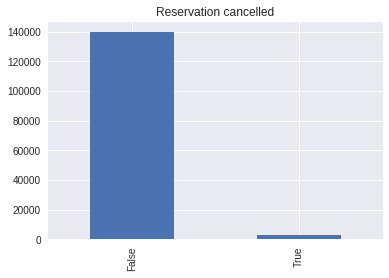

In [29]:
df_reviews.comments.str.contains('The host canceled this reservation').value_counts(dropna=False).plot.bar(title='Reservation cancelled')

### Drop cancelled reservations

In [30]:
df_reviews = df_reviews[~df_reviews.comments.str.contains('The host canceled this reservation')]

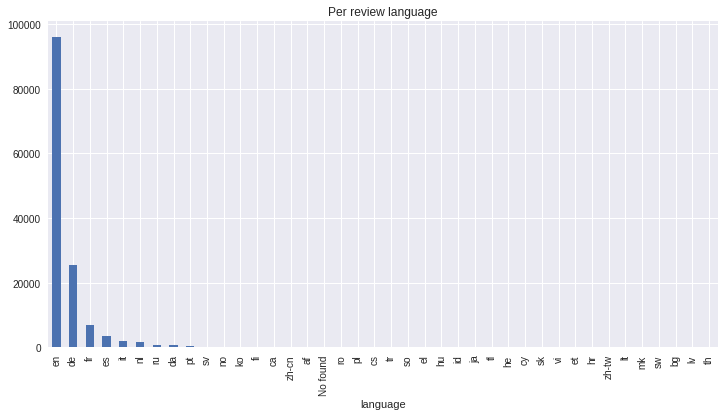

In [31]:
groupy_per_lang = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

groupy_per_lang.plot.bar(title="Per review language",figsize=(12, 6))

In [32]:
df_lang = pd.DataFrame(groupy_per_lang)
df_lang['% total reviews']=np.round(df_lang.comments/df_lang.comments.sum()*100.0,2)
df_lang.head()

,comments,% total reviews
language,,
en,96099,68.86
de,25476,18.25
fr,7021,5.03
es,3664,2.63
it,1907,1.37


From this chart, we will only use reviews written in english (69% of the total reviews)

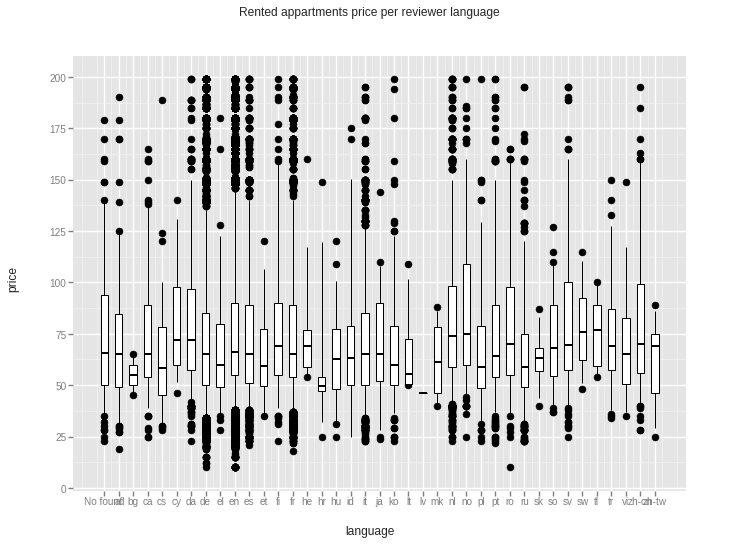

<ggplot: (8761331715777)>

In [33]:
ggplot(df_reviews[df_reviews.price<200],aes(x='language', y='price'))+geom_boxplot() +ggtitle('Rented appartments price per reviewer language')

Out of scope here, but still interesting, the high median price for scandinavian hosts, and low ones for countries from Balkans.

In [ ]:
def concat_comments(x):
    x = x.str.replace(r'[^a-zA-Z\d\s:]','')
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews[df_reviews.language=='en']

df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]

In [34]:
groupy = df_reviews_eng.groupby('listing_id').agg({'comments': [concat_comments,'count'], 'review_scores_rating': 'mean', 'availability_30':'mean','availability_90':'mean','reviews_per_month':'mean'})
groupy.columns = ["_".join(x) for x in groupy.columns.ravel()]
groupy.comments_concat_comments = groupy.comments_concat_comments.str.lower()

In [93]:
groupy.shape

(7009, 7)

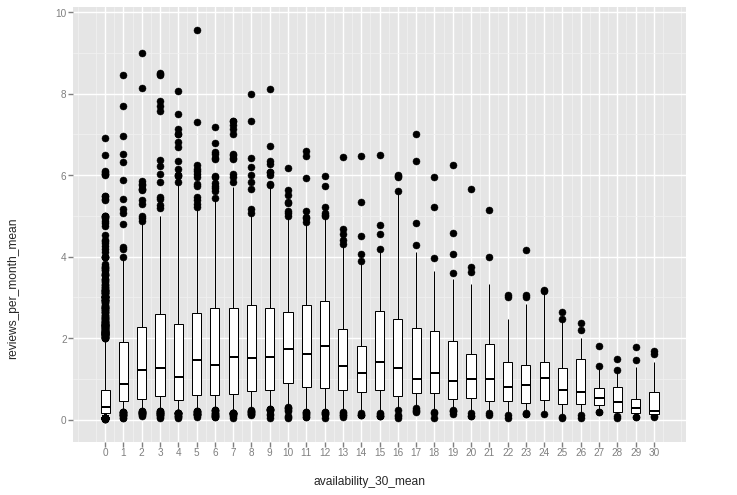

<ggplot: (8761308680901)>

In [35]:
ggplot(groupy,aes(x='availability_30_mean',y='reviews_per_month_mean'))+geom_boxplot()

Critical informations here : The appartments with Zero availability are mostly appartments that are not rented (very low number of reviews per months) rather than fully booked. We can exclude them.

In [36]:
groupy[['review_scores_rating_mean','availability_90_mean','availability_30_mean']].describe()

,review_scores_rating_mean,availability_90_mean,availability_30_mean
count,7009.000000,7009.000000,7009.000000
mean,93.338422,18.706663,4.598516
std,7.400301,24.575723,6.870689
min,20.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000
50%,95.000000,6.000000,0.000000
75%,100.000000,31.000000,7.000000
max,100.000000,90.000000,30.000000


### Remove stop words, host names and Stem text reviews.

#### Host names

In [50]:
all_host_names = df_listing.host_name.str.lower()
all_host_names = all_host_names.unique().tolist()


In [52]:
len(all_host_names)

3213

#### Stop words and stem

In [ ]:
additional_names = ['etienn',]

In [54]:
porter = nltk.stem.porter.PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = nltk.corpus.stopwords.words('english')
stop =list(set(stop)-set(['no', 'not', 'never','don\'t','couldn\'t']))+all_host_names

groupy['good_bad_review']=np.where(groupy.review_scores_rating_mean>94,'good','bad')
X = groupy.comments_concat_comments.values
y = groupy.good_bad_review.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Vectorize text using Tfidf

In [55]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),tokenizer=tokenizer_porter,stop_words=stop,max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train).todense()

### Scale data for PCA

In [56]:
scaler = MinMaxScaler()
X_train_vectorized = scaler.fit_transform(X_train_vectorized)

In [57]:
X_test_vectorized = vectorizer.transform(X_test).todense()
X_test_vectorized = scaler.transform(X_test_vectorized)

### Quick classification overview

In order the check wether using the reviews as predictor, we can run a simple classification tasks on whether the review score is higher than the median value (94%, which balances the dataset):

In [64]:
clf = MultinomialNB()
clf.fit(X_train_vectorized,y_train)
predicted = clf.predict(X_test_vectorized)

In [65]:
print confusion_matrix(y_test,predicted)
print classification_report(predicted,y_test)

[[463 194]
 [217 528]]
             precision    recall  f1-score   support

        bad       0.70      0.68      0.69       680
       good       0.71      0.73      0.72       722

avg / total       0.71      0.71      0.71      1402



Even if not very accurate, using those features could be good additional predictor for our regressor.

In [60]:
idf = vectorizer.idf_
df_idf = pd.DataFrame.from_dict(dict(zip(vectorizer.get_feature_names(), idf)),orient='index')
df_idf.columns=['TFIDF']
df_idf = df_idf.sort_values(by='TFIDF',ascending=False)
df_idf.head()

,TFIDF
marylis wa,8.938802
lanc wa,8.938802
mauric wa,8.938802
nanci wa,8.938802
nestor wa,8.533337


Interesting enough, we can check which stemmed word are weighting the most in this binary classification :

In [61]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizer,clf,n=40)

	-12.1692	etienn wa      		-6.1469	apart wa       
	-12.1692	jena wa        		-6.2957	everyth need   
	-12.1692	marylis wa     		-6.5097	would definit  
	-12.1692	mauric wa      		-6.5107	recommend thi  
	-12.1692	nestor wa      		-6.5766	wa veri        
	-12.1692	nikla wa       		-6.6433	public transport
	-12.1692	no toilet      		-6.8288	stay berlin    
	-12.1692	no toilet paper		-6.8597	veri close     
	-12.1692	rudi wa        		-6.8682	veri help      
	-12.1692	veri dirti     		-6.8766	great locat    
	-12.1692	viliu wa       		-6.8941	would recommend
	-12.1256	bit disappoint 		-6.9024	walk distanc   
	-12.0835	place price    		-6.9106	highli recommend
	-12.0581	natur histori museum		-6.9310	veri clean     
	-12.0248	mathia wa      		-6.9351	- apart        
	-12.0174	not veri clean 		-6.9437	thi apart      
	-11.9694	veri disappoint		-6.9503	berlin -       
	-11.9440	veri bad       		-7.0025	wa great       
	-11.9281	natur histori  		-7.0055	veri well      
	-11.9224	wa howev      

Well, toilet papers, bad internet, broken shower head seem to be a no-go.

### Dimensionality reduction


Now we have scaled vectorized vector using Tfidf, we can reduce the number of columns using a PCA

In [67]:
n_components=300
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train_vectorized)
X_test_svd = svd.transform(X_test_vectorized)

In [63]:
print "Explained variance with {0} components : {1}".format(n_components,svd.explained_variance_ratio_.sum()*100)

Explained variance with 300 components : 20.4013038583


## Add PCA of reviews to dataset :

Finally, we can vectorize the full set with Tfidf, scale it, and use PCA to summarize with only 200 vectors :

In [86]:
X_all_reviews = vectorizer.fit_transform(X).todense()
X_all_reviews_TFIDF_scaled =scaler.fit_transform(X_all_reviews)

In [87]:
print X.shape
print X_all_reviews.shape
print X_all_reviews_TFIDF_scaled.shape

(7009,)
(7009, 20000)
(7009, 20000)


In [88]:
X_all_reviews_PCA = svd.fit_transform(X_all_reviews_TFIDF_scaled)
print svd.explained_variance_ratio_.sum()*100

19.3692650631


Via a PCA, we dropped the reviews matrix from 20000 columns to 300.
We can now append it to the listing dataset :

In [89]:
df_reviews_PCA = pd.DataFrame(X_all_reviews_PCA)
df_reviews_PCA.columns = ['PC_'+str(i) for i in range(1,n_components+1) ]

In [92]:
df_reviews_PCA.shape

(7009, 300)

In [91]:
df_listing.shape

(9208, 218)